In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import json
import cv2

In [2]:
train_df = pd.read_csv('./train/train.csv').drop(columns=['RescuerID', 'Description'])

In [3]:
#df = train_df.merge(train_meta_df[['PetID', 'meta_label']], on='PetID', how='outer')

In [3]:
train_meta_df = pd.DataFrame(glob('./train_metadata/*-1.json'), columns=['file'])
train_meta_df.file = train_meta_df.file.apply(lambda x: x.replace('\\','/'))
train_meta_df['PetID'] = train_meta_df.file.apply(lambda x: x.split('/')[-1].split('-')[0])
train_meta_df = train_meta_df.merge(train_df[['PetID', 'AdoptionSpeed']], on='PetID')

test_meta_df = pd.DataFrame(glob('./test_metadata/*-1.json'), columns=['file'])
test_meta_df.file = test_meta_df.file.apply(lambda x: x.replace('\\','/'))
test_meta_df['PetID'] = test_meta_df.file.apply(lambda x: x.split('/')[-1].split('-')[0])

train_meta_df.tail()

,file,PetID,AdoptionSpeed
14647,./train_metadata/fff4a6420-1.json,fff4a6420,2
14648,./train_metadata/fff6f2f61-1.json,fff6f2f61,2
14649,./train_metadata/fffa39a6a-1.json,fffa39a6a,3
14650,./train_metadata/fffd78a11-1.json,fffd78a11,2
14651,./train_metadata/fffd9b5a8-1.json,fffd9b5a8,1


In [4]:
def read_json(path):
    with open(path, encoding='utf8') as f:
        img = json.load(f)
        return tuple(img.keys())

In [6]:
train_meta = []
for path in train_meta_df.file.values:
    train_meta.append(read_json(path))

In [7]:
from collections import Counter

In [8]:
Counter(train_meta)

Counter({('labelAnnotations',
          'imagePropertiesAnnotation',
          'cropHintsAnnotation'): 13391,
         ('faceAnnotations',
          'labelAnnotations',
          'textAnnotations',
          'imagePropertiesAnnotation',
          'cropHintsAnnotation'): 15,
         ('labelAnnotations',
          'textAnnotations',
          'imagePropertiesAnnotation',
          'cropHintsAnnotation'): 1060,
         ('faceAnnotations',
          'labelAnnotations',
          'imagePropertiesAnnotation',
          'cropHintsAnnotation'): 184,
         ('imagePropertiesAnnotation', 'cropHintsAnnotation'): 2})

In [9]:
train_meta.index(('faceAnnotations',
  'labelAnnotations',
  'textAnnotations',
  'imagePropertiesAnnotation',
  'cropHintsAnnotation'))

8

In [10]:
train_meta_df.file.values[8]

'./train_metadata/002278114-1.json'

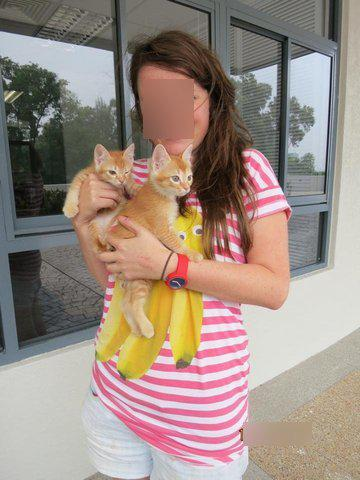

In [11]:
from IPython.display import Image
Image(filename='./train_images/002278114-1.jpg') 

In [12]:
with open(train_meta_df.file.values[8], encoding='utf8') as f:
    img = json.load(f)

### 1. Label Annotations

In [13]:
img['labelAnnotations']

[{'mid': '/m/06z04',
  'description': 'skin',
  'score': 0.9343813,
  'topicality': 0.9343813},
 {'mid': '/m/04rky',
  'description': 'mammal',
  'score': 0.9255103,
  'topicality': 0.9255103},
 {'mid': '/m/01fklc',
  'description': 'pink',
  'score': 0.9227359,
  'topicality': 0.9227359},
 {'mid': '/m/01ssh5',
  'description': 'shoulder',
  'score': 0.8472857,
  'topicality': 0.8472857},
 {'mid': '/m/0ds99lh',
  'description': 'fun',
  'score': 0.77706194,
  'topicality': 0.77706194},
 {'mid': '/m/01jwgf',
  'description': 'product',
  'score': 0.7731236,
  'topicality': 0.7731236},
 {'mid': '/m/0dnr7',
  'description': 'textile',
  'score': 0.77043915,
  'topicality': 0.77043915},
 {'mid': '/m/05r655',
  'description': 'girl',
  'score': 0.76554036,
  'topicality': 0.76554036},
 {'mid': '/m/019nj4',
  'description': 'smile',
  'score': 0.7594943,
  'topicality': 0.7594943},
 {'mid': '/m/09cx8',
  'description': 'finger',
  'score': 0.7216351,
  'topicality': 0.7216351}]

In [14]:
def read_label(path):
    with open(path, encoding='utf8') as f:
        img = json.load(f)
        if 'labelAnnotations' in img.keys():            
            label = img['labelAnnotations'][0]['description']
        else:
            return
    return label

In [15]:
train_meta_df['meta_label'] = train_meta_df.file.apply(read_label)
test_meta_df['meta_label'] = test_meta_df.file.apply(read_label)

In [16]:
train_meta_df.meta_label.unique()

array(['cat', 'dog', 'fauna', 'skin', 'dog breed', 'dog like mammal',
       'animal shelter', 'blue', 'small to medium sized cats', 'black',
       'plant', 'dog breed group', 'floor', 'beagle', 'bull terrier',
       'mammal', 'volpino italiano', 'guinea pig', 'nature reserve',
       'light', 'cage', 'pug', 'siberian husky', 'car', 'wildlife', 'leg',
       'hand', 'face', 'facial expression', 'basset hound', 'snout',
       'photo caption', 'road', 'iron', 'stuffed toy', 'textile',
       'structure', 'product', 'street dog', 'vertebrate', 'furniture',
       'red', 'yellow', 'fashion accessory', 'nose', 'room',
       'cat like mammal', 'electronic device', 'text', 'rock', 'fur',
       'hair', 'tail', 'white', 'grass', 'stairs', 'kennel', 'footwear',
       'people', None, 'ear', 'wood', 'collage', 'whiskers', 'window',
       'plush', 'clothing', 'black cat', 'boston terrier', 'pink',
       'property', 'tire', 'tree', 'meal', 'facial hair', 'table',
       'snapshot', 'road bic

In [18]:
animal_label = ['cat', 'dog', 'fauna', 'dog breed', 'dog like mammal', 'animal shelter', 'small to medium sized cats',
               'dog breed group', 'bull terrier', 'mammal', 'volpino italiano', 'pug', 'siberian husky', 'basset hound',
               'street dog', 'cat like mammal', 'black cat', 'boston terrier', 'czechoslovakian wolfdog', 'dog clothes']
non_animal_label = set(train_meta_df.meta_label.unique()) ^ set(animal_label)

In [19]:
print(non_animal_label)

{'skin', 'car', 'fur', 'structure', 'tail', 'textile', 'wood', 'snout', 'photo caption', 'plant', 'hair', 'collage', 'snapshot', 'light', 'facial hair', 'stairs', 'leg', 'guinea pig', 'fashion accessory', 'white', 'blue', 'road', 'product', 'text', 'wildlife', 'clothing', 'nose', 'nature reserve', 'people', 'whiskers', None, 'electronic device', 'ear', 'window', 'property', 'cage', 'face', 'road bicycle', 'rock', 'plush', 'wheel', 'table', 'footwear', 'beagle', 'tire', 'black', 'floor', 'room', 'meal', 'yellow', 'facial expression', 'stuffed toy', 'iron', 'tree', 'grass', 'vertebrate', 'red', 'furniture', 'hand', 'pink', 'kennel'}


In [20]:
train_meta_df['animal_label'] = train_meta_df.meta_label.apply(lambda x: 1 if x in animal_label else 0)
test_meta_df['animal_label'] = test_meta_df.meta_label.apply(lambda x: 1 if x in animal_label else 0)
train_meta_df.tail()

,file,PetID,AdoptionSpeed,meta_label,animal_label
14647,./train_metadata/fff4a6420-1.json,fff4a6420,2,dog,1
14648,./train_metadata/fff6f2f61-1.json,fff6f2f61,2,dog,1
14649,./train_metadata/fffa39a6a-1.json,fffa39a6a,3,cat,1
14650,./train_metadata/fffd78a11-1.json,fffd78a11,2,cat,1
14651,./train_metadata/fffd9b5a8-1.json,fffd9b5a8,1,dog like mammal,1


Text(0.5, 1.0, 'image with non-aninmal label')

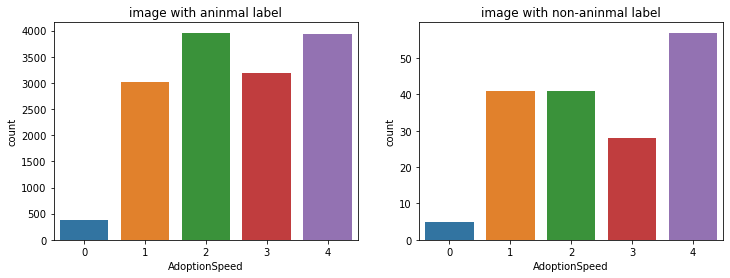

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.countplot(x='AdoptionSpeed', data=train_meta_df.loc[train_meta_df.animal_label == 1])
plt.title('image with aninmal label')
plt.subplot(122)
sns.countplot(x='AdoptionSpeed', data=train_meta_df.loc[train_meta_df.animal_label == 0])
plt.title('image with non-aninmal label')

### 2. Image Properties Annotation

In [22]:
img['imagePropertiesAnnotation']['dominantColors']['colors']

[{'color': {'red': 196, 'green': 198, 'blue': 197},
  'score': 0.14477752,
  'pixelFraction': 0.1623112},
 {'color': {'red': 114, 'green': 116, 'blue': 115},
  'score': 0.102673166,
  'pixelFraction': 0.13497962},
 {'color': {'red': 176, 'green': 159, 'blue': 133},
  'score': 0.080558434,
  'pixelFraction': 0.050827138},
 {'color': {'red': 211, 'green': 133, 'blue': 164},
  'score': 0.03760698,
  'pixelFraction': 0.023735315},
 {'color': {'red': 218, 'green': 191, 'blue': 93},
  'score': 0.036583304,
  'pixelFraction': 0.010948613},
 {'color': {'red': 85, 'green': 87, 'blue': 82},
  'score': 0.07329706,
  'pixelFraction': 0.08135539},
 {'color': {'red': 220, 'green': 222, 'blue': 217},
  'score': 0.05640333,
  'pixelFraction': 0.062015504},
 {'color': {'red': 49, 'green': 52, 'blue': 48},
  'score': 0.05218084,
  'pixelFraction': 0.053464398},
 {'color': {'red': 156, 'green': 156, 'blue': 154},
  'score': 0.038967233,
  'pixelFraction': 0.04419404},
 {'color': {'red': 228, 'green': 183

In [48]:
def dominant_color(path):
    with open(path, encoding='utf8') as f:
        img = json.load(f)           
        color = img['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']
    return max(color, key=color.get)

In [50]:
dominant_color_cnt = Counter(train_meta_df.file.apply(dominant_color))
dominant_color_cnt

Counter({'red': 11542, 'blue': 1761, 'green': 1349})

<AxesSubplot:>

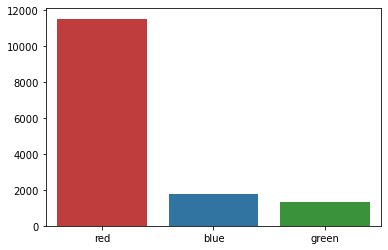

In [77]:
sns.barplot(x=list(dominant_color_cnt.keys()), y=list(dominant_color_cnt.values()), palette=["C3", "C0", "C2"])

In [25]:
train_meta_df['dominant_color'] = train_meta_df.file.apply(dominant_color)

In [26]:
group_color = train_meta_df.groupby(['AdoptionSpeed', 'dominant_color'])['PetID'].count()
group_color = group_color.reset_index(level=['AdoptionSpeed', 'dominant_color'])

In [27]:
dominant_blue = group_color.iloc[range(0,len(group_color),3)].PetID
dominant_green = group_color.iloc[range(1,len(group_color),3)].PetID
dominant_red = group_color.iloc[range(2,len(group_color),3)].PetID

dominant_blue = dominant_blue/dominant_blue.mean()
dominant_green = dominant_green/dominant_green.mean()
dominant_red = dominant_red/dominant_red.mean()

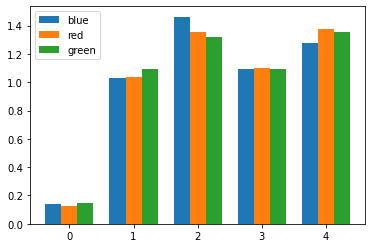

In [28]:
labels = [0,1,2,3,4]
fig, ax = plt.subplots()
x = np.arange(len(labels))
width = 0.25
rects1 = ax.bar(x - width, dominant_blue, width, label='blue')
rects2 = ax.bar(x, dominant_red, width, label='red')
rects3 = ax.bar(x + width, dominant_green, width, label='green')
ax.legend()

In [29]:
def sum_color(path):
    with open(path, encoding='utf8') as f:
        img = json.load(f)           
        total_color = sum(img['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color'].values())
    return total_color

In [30]:
train_meta_df['sum_color'] = train_meta_df.file.apply(sum_color)

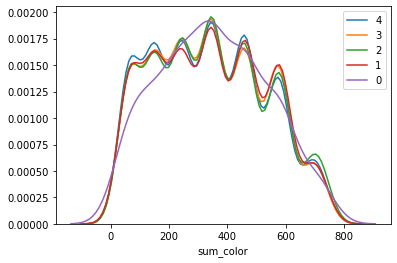

In [31]:
plt.figure(figsize=(6,4))
sns.distplot(train_meta_df.loc[train_meta_df.AdoptionSpeed == 4, 'sum_color'], hist=False, label=4)
sns.distplot(train_meta_df.loc[train_meta_df.AdoptionSpeed == 3, 'sum_color'], hist=False, label=3)
sns.distplot(train_meta_df.loc[train_meta_df.AdoptionSpeed == 2, 'sum_color'], hist=False, label=2)
sns.distplot(train_meta_df.loc[train_meta_df.AdoptionSpeed == 1, 'sum_color'], hist=False, label=1)
sns.distplot(train_meta_df.loc[train_meta_df.AdoptionSpeed == 0, 'sum_color'], hist=False, label=0)

In [32]:
train_meta_df.tail()

,file,PetID,AdoptionSpeed,meta_label,animal_label,dominant_color,sum_color
14647,./train_metadata/fff4a6420-1.json,fff4a6420,2,dog,1,red,393
14648,./train_metadata/fff6f2f61-1.json,fff6f2f61,2,dog,1,red,78
14649,./train_metadata/fffa39a6a-1.json,fffa39a6a,3,cat,1,red,350
14650,./train_metadata/fffd78a11-1.json,fffd78a11,2,cat,1,red,719
14651,./train_metadata/fffd9b5a8-1.json,fffd9b5a8,1,dog like mammal,1,red,356


In [33]:
train_meta_df.drop(columns=['dominant_color', 'sum_color'], inplace=True)

In [34]:
def read_dominant_red(path):
    with open(path, encoding='utf8') as f:
        img = json.load(f)           
        red_color = img['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red']
    return red_color

def read_dominant_green(path):
    with open(path, encoding='utf8') as f:
        img = json.load(f)           
        green_color = img['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green']
    return green_color

def read_dominant_blue(path):
    with open(path, encoding='utf8') as f:
        img = json.load(f)           
        blue_color = img['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue']
    return blue_color

In [35]:
train_meta_df['red'] = train_meta_df.file.apply(read_dominant_red)
train_meta_df['green'] = train_meta_df.file.apply(read_dominant_green)
train_meta_df['blue'] = train_meta_df.file.apply(read_dominant_blue)

test_meta_df['red'] = test_meta_df.file.apply(read_dominant_red)
test_meta_df['green'] = test_meta_df.file.apply(read_dominant_green)
test_meta_df['blue'] = test_meta_df.file.apply(read_dominant_blue)
train_meta_df.tail()

,file,PetID,AdoptionSpeed,meta_label,animal_label,red,green,blue
14647,./train_metadata/fff4a6420-1.json,fff4a6420,2,dog,1,199,139,55
14648,./train_metadata/fff6f2f61-1.json,fff6f2f61,2,dog,1,28,25,25
14649,./train_metadata/fffa39a6a-1.json,fffa39a6a,3,cat,1,139,121,90
14650,./train_metadata/fffd78a11-1.json,fffd78a11,2,cat,1,245,234,240
14651,./train_metadata/fffd9b5a8-1.json,fffd9b5a8,1,dog like mammal,1,121,115,120


### 3. Face Annotations

In [36]:
img['faceAnnotations'][0].keys()

dict_keys(['boundingPoly', 'fdBoundingPoly', 'landmarks', 'rollAngle', 'panAngle', 'tiltAngle', 'detectionConfidence', 'landmarkingConfidence', 'joyLikelihood', 'sorrowLikelihood', 'angerLikelihood', 'surpriseLikelihood', 'underExposedLikelihood', 'blurredLikelihood', 'headwearLikelihood'])

In [37]:
len(img['faceAnnotations'][0].keys())

15

In [38]:
img['faceAnnotations'][0]

{'boundingPoly': {'vertices': [{'x': 121, 'y': 36},
   {'x': 223, 'y': 36},
   {'x': 223, 'y': 155},
   {'x': 121, 'y': 155}]},
 'fdBoundingPoly': {'vertices': [{'x': 136, 'y': 76},
   {'x': 213, 'y': 76},
   {'x': 213, 'y': 153},
   {'x': 136, 'y': 153}]},
 'landmarks': [{'type': 'LEFT_EYE',
   'position': {'x': 154.4033, 'y': 102.54831, 'z': 1.8858487e-05}},
  {'type': 'RIGHT_EYE',
   'position': {'x': 186.2425, 'y': 97.6536, 'z': -1.8247472}},
  {'type': 'LEFT_OF_LEFT_EYEBROW',
   'position': {'x': 143.30145, 'y': 97.325485, 'z': 1.384743}},
  {'type': 'RIGHT_OF_LEFT_EYEBROW',
   'position': {'x': 161.49623, 'y': 96.73959, 'z': -8.430881}},
  {'type': 'LEFT_OF_RIGHT_EYEBROW',
   'position': {'x': 176.6378, 'y': 94.48152, 'z': -9.266601}},
  {'type': 'RIGHT_OF_RIGHT_EYEBROW',
   'position': {'x': 194.76018, 'y': 89.76374, 'z': -1.5905604}},
  {'type': 'MIDPOINT_BETWEEN_EYES',
   'position': {'x': 169.7655, 'y': 100.67699, 'z': -7.543981}},
  {'type': 'NOSE_TIP',
   'position': {'x': 

In [28]:
train_meta_df['face_annot'] = 0

In [29]:
for i, meta_dict in enumerate(train_meta):
    if 'faceAnnotations' in meta_dict:
        train_meta_df['face_annot'][i] = 1

C:\Users\Admin\AppData\Local\Temp/ipykernel_10764/2684955116.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_meta_df['face_annot'][i] = 1


In [41]:
train_meta_df.tail()

,file,PetID,AdoptionSpeed,meta_label,animal_label,red,green,blue,face_annot
14647,./train_metadata/fff4a6420-1.json,fff4a6420,2,dog,1,199,139,55,0
14648,./train_metadata/fff6f2f61-1.json,fff6f2f61,2,dog,1,28,25,25,0
14649,./train_metadata/fffa39a6a-1.json,fffa39a6a,3,cat,1,139,121,90,0
14650,./train_metadata/fffd78a11-1.json,fffd78a11,2,cat,1,245,234,240,0
14651,./train_metadata/fffd9b5a8-1.json,fffd9b5a8,1,dog like mammal,1,121,115,120,0


Text(0.5, 1.0, 'image without face annotation')

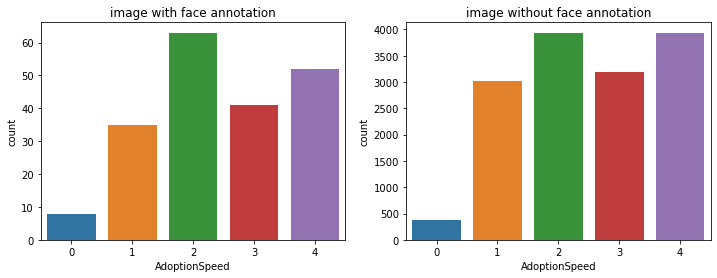

In [30]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.countplot(x='AdoptionSpeed', data=train_meta_df.loc[train_meta_df.face_annot == 1])
plt.title('image with face annotation')
plt.subplot(122)
sns.countplot(x='AdoptionSpeed', data=train_meta_df.loc[train_meta_df.face_annot == 0])
plt.title('image without face annotation')

In [44]:
train_meta_df.drop(columns='face_annot', inplace=True)

### 4. Text Annotations

In [45]:
img['textAnnotations'][0]

{'locale': 'en',
 'description': '/09/XXXX\n',
 'boundingPoly': {'vertices': [{'x': 248, 'y': 427},
   {'x': 307, 'y': 427},
   {'x': 307, 'y': 441},
   {'x': 248, 'y': 441}]}}

In [31]:
text_locale = []
for i in range(len(train_meta_df)):
    with open(train_meta_df.file.values[i], encoding='utf8') as f:
        img_2 = json.load(f)
        if 'textAnnotations' in img_2.keys():            
            text_locale.append(img_2['textAnnotations'][0]['locale'])
print(set(text_locale))

{'id', 'fy', 'mt', 'et', 'sw', 'gl', 'mi', 'da', 'nl', 'is', 'lt', 'pl', 'cy', 'es', 'sk', 'fr', 'ht', 'zh-Hant', 'to', 'sv', 'sr', 'ja', 'uz', 'tr', 'jv', 'gd', 'fi', 'fil', 'ms', 'eo', 'yo', 'de', 'la', 'sq', 'eu', 'co', 'no', 'af', 'ku', 'zh', 'ro', 'ga', 'ko', 'lb', 'br', 'su', 'it', 'th', 'qu', 'cs', 'hu', 'hr', 'sl', 'pt-PT', 'lv', 'ca', 'oc', 'en'}


In [62]:
len(text_locale), len(set(text_locale))

(1075, 58)

In [32]:
def read_text_locale(path):
    with open(path, encoding='utf8') as f:
        img = json.load(f)
        if 'textAnnotations' in img.keys():            
            locale = img['textAnnotations'][0]['locale']
        else:
            return 'None'
    return locale

In [33]:
train_meta_df['text_annot'] = train_meta_df.file.apply(read_text_locale)
test_meta_df['text_annot'] = test_meta_df.file.apply(read_text_locale)

In [40]:
train_meta_df.text_annot.value_counts()

None       13577
en           686
ms            44
fr            27
zh            24
fil           18
la            18
uz            11
mt            10
sv            10
fi            10
it             9
sq             9
es             8
pt-PT          8
ja             8
de             8
da             7
nl             7
zh-Hant        7
qu             7
hr             6
sw             6
eo             6
jv             6
su             6
id             6
ro             6
lb             6
mi             6
et             6
ca             5
no             5
br             5
lv             5
fy             5
yo             4
sr             4
oc             4
af             3
co             3
eu             3
is             3
cy             3
sl             3
gl             3
hu             3
pl             3
ga             2
gd             2
cs             2
tr             2
to             1
lt             1
ht             1
ku             1
ko             1
sk             1
th            

In [45]:
train_meta_df['text_annot_2'] = train_meta_df['text_annot'].apply(lambda x: x=='None')

Text(0.5, 1.0, 'image without text annotation')

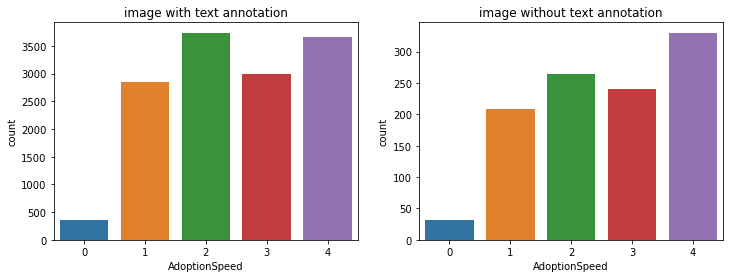

In [46]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.countplot(x='AdoptionSpeed', data=train_meta_df.loc[train_meta_df.text_annot_2 == True])
plt.title('image with text annotation')
plt.subplot(122)
sns.countplot(x='AdoptionSpeed', data=train_meta_df.loc[train_meta_df.text_annot_2 == False])
plt.title('image without text annotation')

In [105]:
train_meta_df.tail()

,file,PetID,AdoptionSpeed,meta_label,animal_label,red,green,blue,text_annot
14647,./train_metadata/fff4a6420-1.json,fff4a6420,2,dog,1,199,139,55,None
14648,./train_metadata/fff6f2f61-1.json,fff6f2f61,2,dog,1,28,25,25,None
14649,./train_metadata/fffa39a6a-1.json,fffa39a6a,3,cat,1,139,121,90,None
14650,./train_metadata/fffd78a11-1.json,fffd78a11,2,cat,1,245,234,240,None
14651,./train_metadata/fffd9b5a8-1.json,fffd9b5a8,1,dog like mammal,1,121,115,120,None


### 5. Crop Hint Annotation

In [69]:
img['cropHintsAnnotation']['cropHints'][0]

{'boundingPoly': {'vertices': [{},
   {'x': 359},
   {'x': 359, 'y': 479},
   {'y': 479}]},
 'confidence': 1,
 'importanceFraction': 0.59}

In [70]:
cv2.imread('./train_images/002278114-1.jpg').shape

(480, 360, 3)

In [71]:
vertex_x = []
vertex_y = []
for path in train_meta_df.file:
    with open(path, encoding='utf8') as f:
        img = json.load(f)
        vertex_x.append(img['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x'])
        vertex_y.append(img['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y'])
vertex_x[:10]

[348, 359, 399, 298, 399, 639, 299, 399, 359, 399]

In [72]:
vertex_y[:10]

[478, 479, 267, 399, 266, 479, 399, 399, 479, 265]

In [73]:
count = 0
for i in range(len(train_meta_df)):
    height, width, _ = cv2.imread('./train_images/%s-1.jpg' %train_meta_df.PetID[i]).shape
    diff_x = width - vertex_x[i] - 1
    diff_y = height - vertex_y[i] - 1
    if diff_x > 10 or diff_y > 10:
        count += 1
count

380

In [74]:
count/len(train_meta_df)*100

2.5935025935025937

### Summary

In [110]:
train_meta_df.drop(columns='file', inplace=True)
test_meta_df.drop(columns='file', inplace=True)

In [42]:
X_meta_full = pd.concat([train_meta_df, test_meta_df])

In [51]:
le = LabelEncoder()
X_meta_full.text_annot = le.fit_transform(X_meta_full.text_annot)

In [64]:
scaler = StandardScaler()
X_meta_full.text_annot = scaler.fit_transform(pd.DataFrame(X_meta_full.text_annot))

In [67]:
train_meta_df = X_meta_full[:len(X_meta_train)]
test_meta_df = X_meta_full[len(X_meta_train):]

In [71]:
train_meta_df.to_csv('train_meta_df.csv', index=False)
test_meta_df.to_csv('test_meta_df.csv', index=False)

In [111]:
pd.DataFrame(train_meta_df).to_csv('train_meta_df.csv', index=False)
pd.DataFrame(test_meta_df).to_csv('test_meta_df.csv', index=False)